In [180]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import math
from matplotlib import dates as mpl_dates
%matplotlib inline

# input the data

In [181]:
df=pd.read_csv(r"../../Lectures/Lecture 3/data/hw3.csv")

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2667 entries, 0 to 2666
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ts         2667 non-null   object 
 1   open       2667 non-null   float64
 2   high       2163 non-null   float64
 3   low        2378 non-null   float64
 4   close      2531 non-null   float64
 5   volume     2667 non-null   float64
 6   volumeUSD  0 non-null      float64
 7   token      2667 non-null   object 
 8   chain      2667 non-null   object 
dtypes: float64(6), object(3)
memory usage: 187.6+ KB


In [183]:
df["token"].value_counts()

BTC                                   323
COMP                                  322
CRV                                   318
SOL                                   318
USDT                                  314
UNI                                   312
AAVE                                  312
ETH                                   298
<span name="tokenName">UNI</span>      30
<span name="tokenName">ETH</span>      28
<span name="tokenName">USDT</span>     19
<span name="tokenName">CRV</span>      17
<span name="tokenName">SOL</span>      16
<span name="tokenName">AAVE</span>     16
<span name="tokenName">BTC</span>      14
<span name="tokenName">COMP</span>     10
Name: token, dtype: int64

In [184]:
df["chain"].value_counts()

ETH     1663
BTC      337
SOL      334
USDT     333
Name: chain, dtype: int64

In [185]:
df.duplicated().sum()

307

# data cleaning 

1. drop duplicates

In [186]:
df.drop_duplicates(inplace=True)

2. clean the token column

In [187]:
df.loc[df['token'].str.contains('</span>'), 'token'] = df.loc[df['token'].str.contains('</span>'), 'token'].str.extract('<span name="tokenName">(.*)<\/span>')[0]

In [188]:
df["token"].value_counts()

UNI     295
CRV     295
SOL     295
ETH     295
AAVE    295
USDT    295
COMP    295
BTC     295
Name: token, dtype: int64

In [189]:
df["chain"].value_counts()

ETH     1475
SOL      295
USDT     295
BTC      295
Name: chain, dtype: int64

3. sort the value and transform ts to datetime

In [190]:
df.sort_values(by=["token","ts"],inplace=True)

In [191]:
df.ts=pd.to_datetime(df.ts)

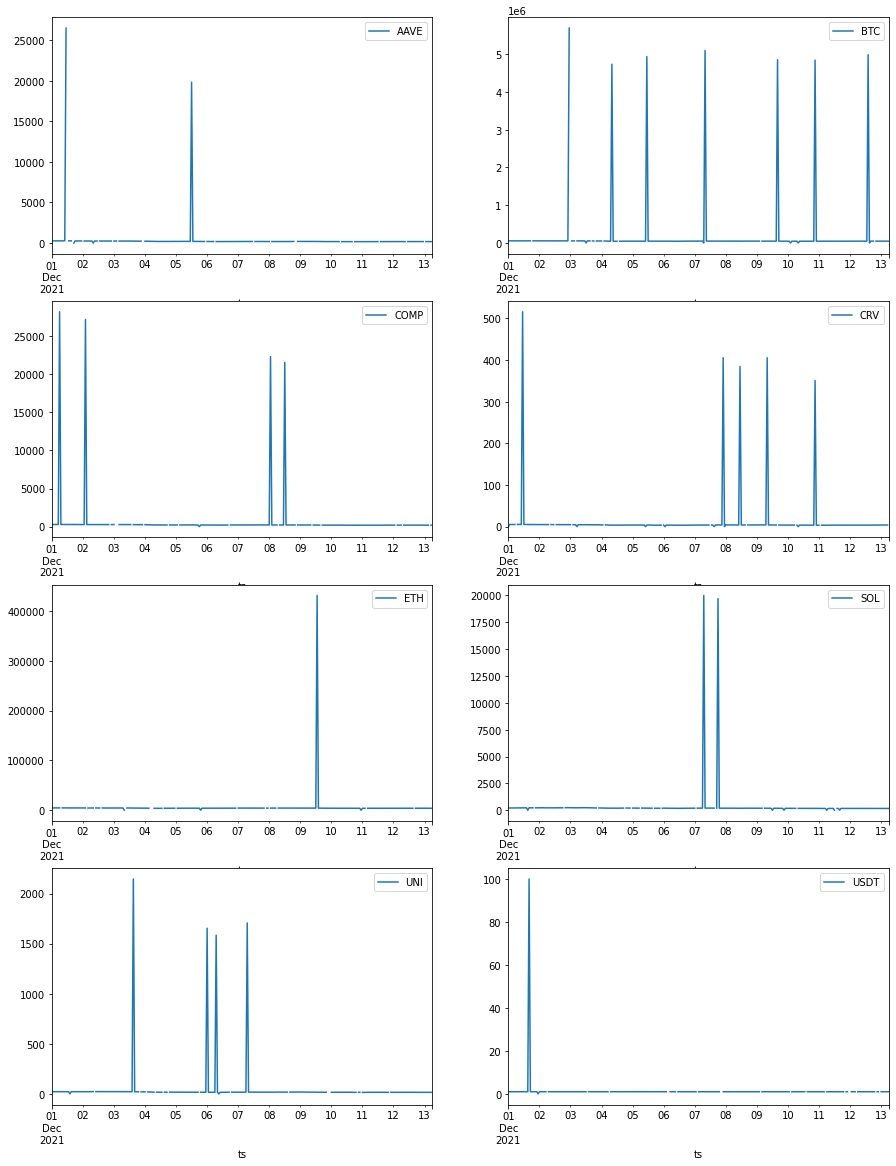

In [192]:
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'close',"ts"]].groupby('token'):
    df_token.set_index("ts")['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1


4. cleaning for close

In [193]:
df[["open","high","low","close"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2360 entries, 2199 to 2031
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2360 non-null   float64
 1   high    1910 non-null   float64
 2   low     2104 non-null   float64
 3   close   2244 non-null   float64
dtypes: float64(4)
memory usage: 92.2 KB


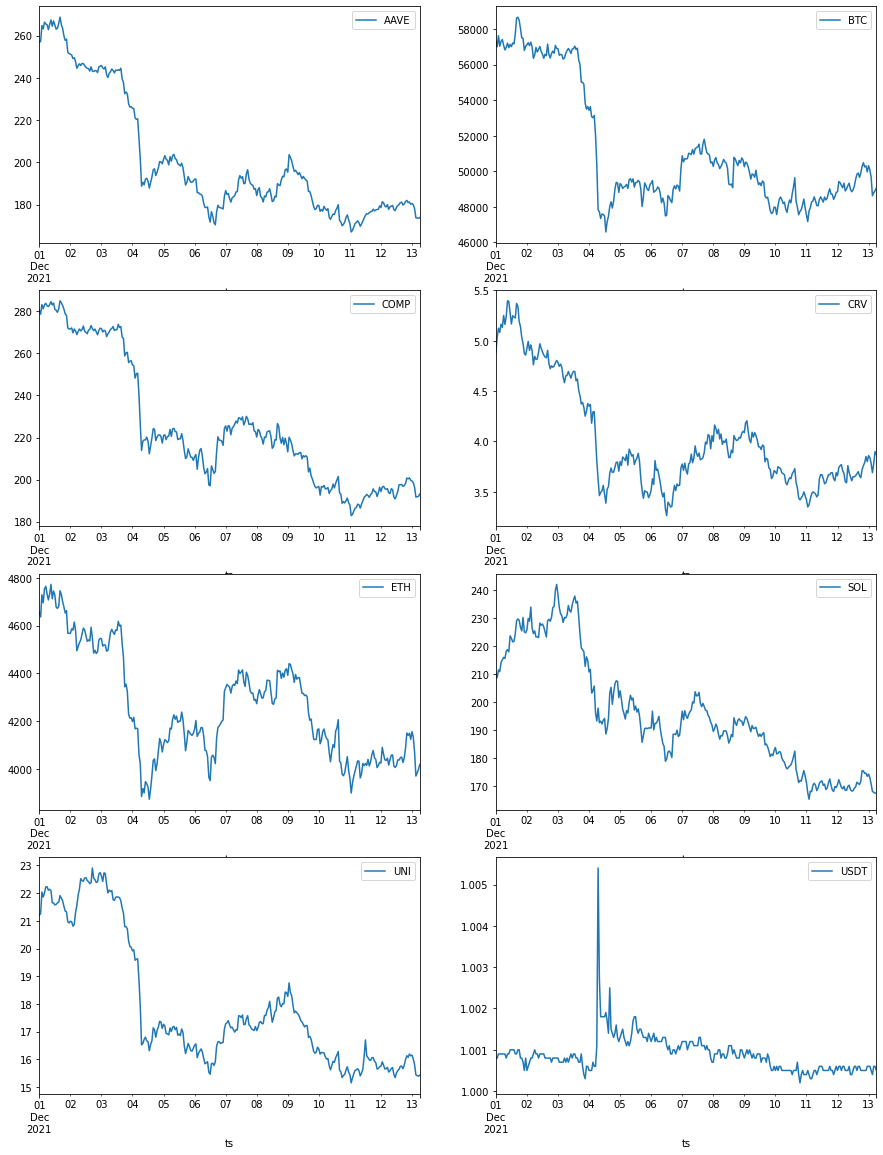

In [194]:
#Since open has full data, we graph open data as following

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'open',"ts"]].groupby('token'):
    df_token.set_index("ts")['open'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1


In [195]:
df.loc[df.close / df.open >= 2, 'close'] = 0.5 * (df.loc[df.close / df.open >= 2, 'high'] + df.loc[df.close / df.open >= 2, 'low'])
df.loc[df.close / df.open <=0.5, 'close'] = 0.5 * (df.loc[df.close / df.open <=0.5, 'high'] + df.loc[df.close / df.open <=0.5, 'low'])

In [196]:
# for rows with valid high and low price but invalid close
df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(),"close"]=0.5*(df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(),"high"]+df.loc[df.close.isnull() & df.high.notnull() & df.low.notnull(),"low"])

In [197]:
# for rows with only valid high 
df.loc[df.close.isnull() & df.high.notnull() & df.low.isnull(),"close"]=0.5*(df.loc[df.close.isnull() & df.high.notnull() & df.low.isnull(),"high"]+df.loc[df.close.isnull() & df.high.notnull() & df.low.isnull(),"open"])

In [198]:
# for rows with only valid low
df.loc[df.close.isnull() & df.low.notnull() & df.high.isnull(),"close"]=0.5*(df.loc[df.close.isnull() & df.low.notnull() & df.high.isnull(),"low"]+df.loc[df.close.isnull() & df.low.notnull() & df.high.isnull(),"open"])

In [199]:
# for rows only with open
df.loc[df.close.isnull() & df.high.isnull() & df.low.isnull(),"close"]=df.loc[df.close.isnull() & df.high.isnull() & df.low.isnull(),"open"]

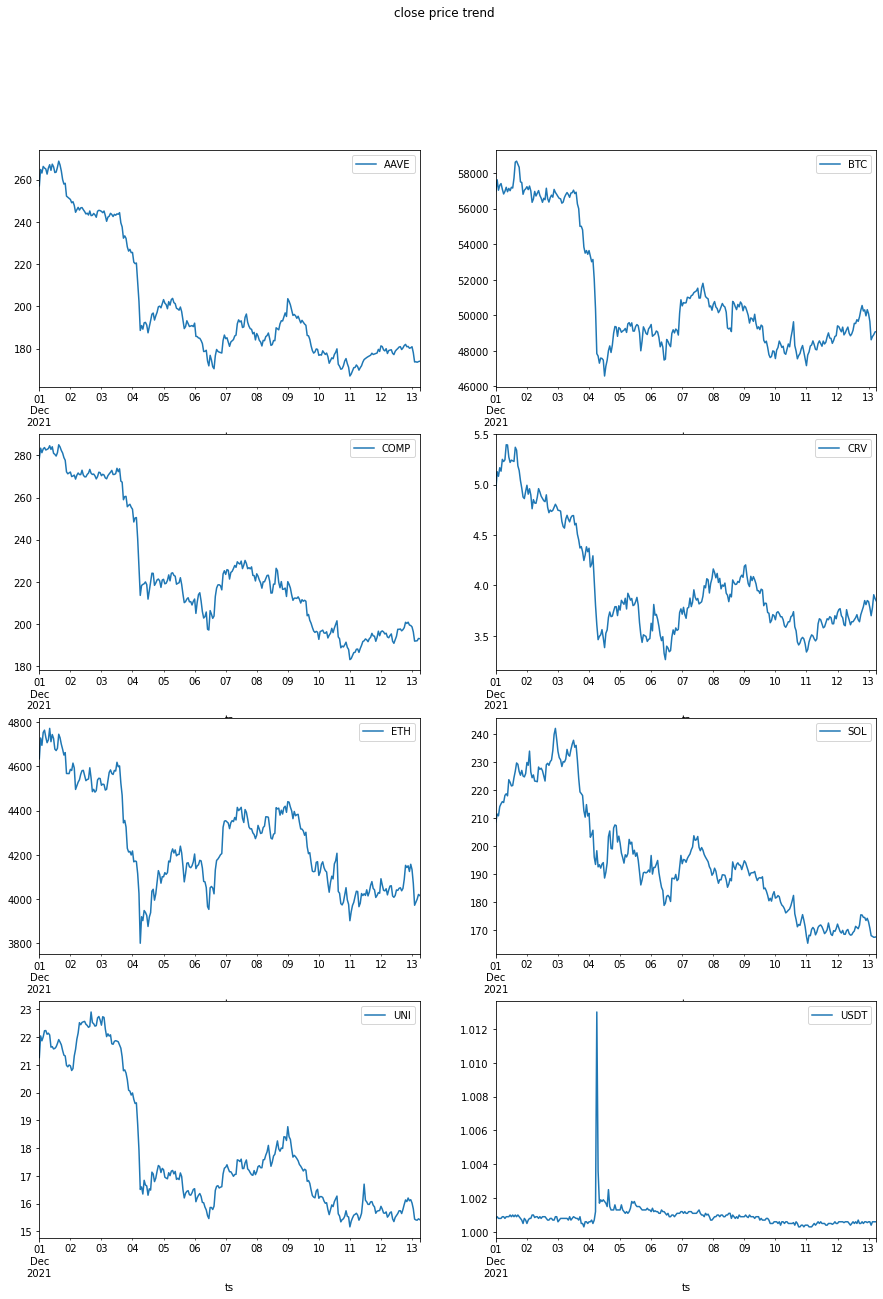

In [206]:
# graph the close data

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))
fig.suptitle("close price trend")
idx = 0
for label, df_token in df[['token', 'close',"ts"]].groupby('token'):
    df_token.set_index("ts")['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1

5. clean the volume data

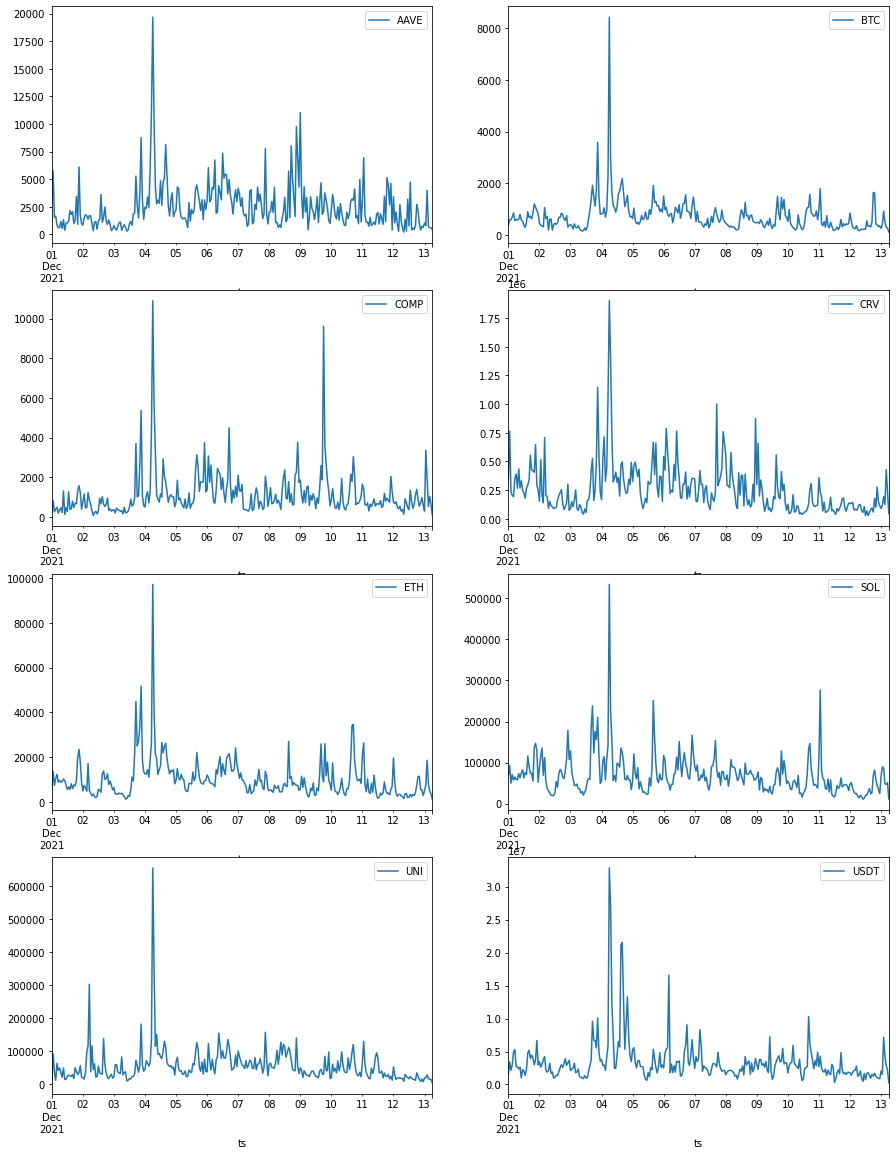

In [202]:
# graph the volume data

tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token', 'volume',"ts"]].groupby('token'):
    df_token.set_index("ts")['volume'].plot(ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    
    idx += 1

The volume data is reasonable

# calculate the volumeUSD

In [207]:
df["volumeUSD"]=df["volume"]*df["close"]

In [208]:
df.groupby("chain")["volumeUSD"].sum()

chain
BTC     1.095893e+10
ETH     1.364762e+10
SOL     4.075514e+09
USDT    1.008247e+09
Name: volumeUSD, dtype: float64